# Evaluate DO outcome from 50% and 100% river loading reductions
From Joel: reducing the river loads by 50% (2a) has a bigger impact than reducing them entirely (1c)...why?

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

In [6]:
run_folders=["2a_sog_river_0.5times", "1c_all_sog_riv_off"]
root_dir=pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/SOG_NB/DOXG/")
paths={}

# Create list of file paths
file_paths=[]
for run in run_folders:
    file_paths.append(root_dir/run/"daily_min_DOXG.nc")

# Load config file
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']
    
# Loast shapefile 
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Load minimum DO results from scenario
MinDO_full={}
MinDO={}
for idx,run_file in enumerate(file_paths):
    print(f'loading {run_folders[idx]} file')
    try: 
        with xarray.open_dataset(run_file) as ds:
            print([*ds])
            MinDO_full[run_folders[idx]]=ds[f'DOXG_daily_min']
            # Sub-sample nodes (from 16012 nodes to 7494)
            MinDO[run_folders[idx]]=MinDO_full[run_folders[idx]][:,:,gdf['node_id']-1]
            print(MinDO[run_folders[idx]].shape)
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')

loading 2a_sog_river_0.5times file
['DOXG_daily_min']
(361, 10, 4144)
loading 1c_all_sog_riv_off file
['DOXG_daily_min']
(361, 10, 4144)


### Take the DO difference between the two runs
WOW.  This difference cals takes FOREVER! 

In [11]:
%%time
DO_diff = MinDO["1c_all_sog_riv_off"] - MinDO["2a_sog_river_0.5times"]

### Find min DO 
2a: 50% reduction
1c: 100% reduction
Reducing nutrient loading by 100% ought to results in higher DO values than reducing loading by 50%, i.e. DO[2a] < DO[1c]...min_DO[2a] < min_DO[1c].
min_DO[1c] - min_DO[2a] > 0...unless the world is wonky.  Take the minimum across depth and time to find out where values are negative and if the world is wonky

In [12]:
DO_diff_min = DO_diff.min(axis=1).min(axis=0)

In [13]:
DO_diff_min.shape

(4144,)

In [14]:
gdf['DO_diff_min'] = DO_diff_min

Text(0.5, 1.0, 'Minimum of Min Daily DO difference (1c-2a)\n 1c:100% reduction\n2a:50% reduction\nExpect:1c-2a>0')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


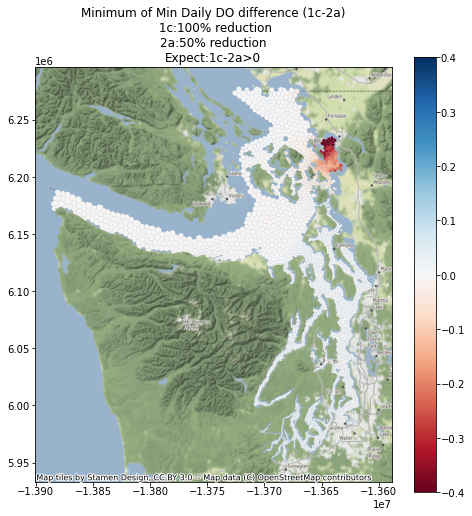

In [29]:
fig, axs = plt.subplots(1, figsize = (8,8))
gdf.plot(ax=axs,
        column='DO_diff_min',
        cmap='RdBu',
        legend=True, vmin=-.4, vmax=.4)
cx.add_basemap(axs, crs=gdf.crs,alpha=1)
axs.set_title('Minimum of Min Daily DO difference (1c-2a)\n 1c:100% reduction\n2a:50% reduction\nExpect:1c-2a>0')
# axs.set_ylim(5.22e6,5.27e6)
# axs.set_xlim(5.1e5,5.5e5)

(-13700000.0, -13620000.0)

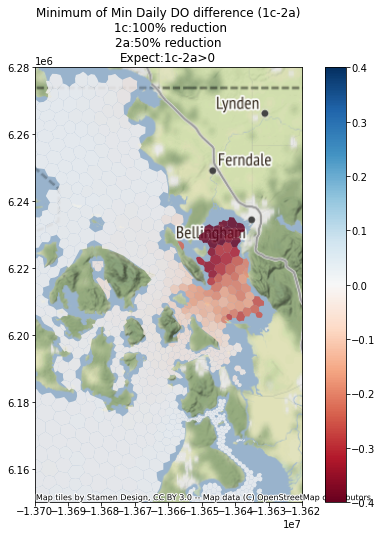

In [32]:
fig, axs = plt.subplots(1, figsize = (8,8))
gdf.plot(ax=axs,
        column='DO_diff_min',
        cmap='RdBu',
        legend=True, vmin=-.4, vmax=.4,alpha = 0.8)
cx.add_basemap(axs, crs=gdf.crs)
axs.set_title('Minimum of Min Daily DO difference (1c-2a)\n 1c:100% reduction\n2a:50% reduction\nExpect:1c-2a>0')
axs.set_ylim(6.15e6,6.28e6)
axs.set_xlim(-1.37e7,-1.362e7)